In [8]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from lmfit import minimize, Parameters, report_fit
import random
import warnings
import matplotlib.pyplot as plt

In [9]:
#Preliminaries
PATH_TO_DATA = '../../../Data/Matthews2018/Digitized/Intracellular/'

data_5mg = pd.read_csv(PATH_TO_DATA+'ICPK5mg_shortTerm.csv')
data_025mg = pd.read_csv(PATH_TO_DATA+'ICPK025mg_shortTerm.csv')
data_075mg = pd.read_csv(PATH_TO_DATA+'ICPK075mg_shortTerm.csv')

data_5mg = data_5mg.dropna(axis='columns')
data_025mg = data_025mg.dropna(axis='columns')
data_075mg = data_075mg.dropna(axis='columns')

data_5mg.columns = ['time','conc']
data_025mg.columns = ['time','conc']
data_075mg.columns = ['time','conc']

datalist = [data_5mg, data_025mg, data_075mg]

for d in datalist:
    d['conc'] = 10**d['conc']

t_observed = []; z_observed = []
for d in range(len(datalist)):
    t_observed.append(datalist[d].time.tolist())
    z_observed.append(datalist[d].conc.tolist())


In [10]:
#Compartment model linear PK
def model_TP_linear(t, z):
    Z0 = z[0]; Z1 = z[1]; Z2 = z[2]; Z3 = z[3]
    dZ0 = -ka*Z0
    dZ1 = (ka/Vc)*Z0 - k10*Z1 - k12*Z1 + k21*Z2
    dZ2 = k12*Z1 - k21*Z2
    dZ3 = k13*Z1 - k30*Z3
    d = [dZ0,dZ1,dZ2,dZ3]
    return d

def simulation(d, t_obs):
    #initial state of the system
    z0 = [d, 0, 0, 0]
    t0 = 0; tfinal = 25 #initial and final time of interest
    z = z0
    res = solve_ivp(model_TP_linear, (t0,tfinal), z, t_eval=t_obs)
    Z3List = list(res.y[3]);  
    return Z3List            

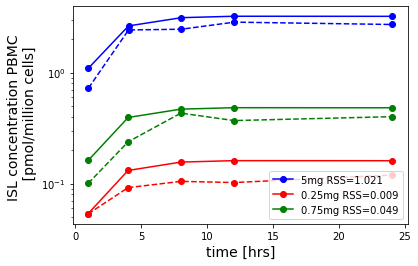

In [11]:
#Estimated PK parameters
ka = 45.4382
k10 =  0.2355
k12 =  0.175
k21 =  0.0259
Vc =  162.69

k13 = 44.2394
k30 = 0.00975


#plot result   
cc = ['bo--','ro--','go--']; cs = ['bo-','ro-','go-'] #color
dose_label = ['5mg', '0.25mg', '0.75mg'] #label
doses = [5, 0.25, 0.75] #drug doses
   
for i in range(len(datalist)):
    Z3 = simulation(doses[i], t_observed[i]) 
    rss=round(np.sum(np.power(np.subtract(Z3,z_observed[i]),2)),3)
    plt.plot(t_observed[i],Z3,cs[i],label = dose_label[i]+' RSS='+str(round(rss,3)))
    plt.plot(t_observed[i],z_observed[i],cc[i],)
plt.xlabel('time [hrs]', fontsize=14)
plt.ylabel('ISL concentration PBMC \n [pmol/million cells]', fontsize=14)
plt.yscale('log')
plt.legend(loc='best')
#plt.title('short Term Measurements & Simulations')
plt.show()